# DATA 620 Project 2
## Gabrielle Bartomeo, Zach Dravis, Peter Lombardo, and Hovig Ohannessian

The outlines of the second project included finding a significantly large data set with two or more groups, reducing the size of the data set, and to make inferences about the groups from analysis performed.

## Abstract

We analyzed weather and rider data provided on [Data.World](https://data.world/colin-lindley/rideaustin-hackathon-driver-happiness) by Colin Lindley from the RideAustin Hackathon from 2016 to 2017. The data set was narrowed down by only examining rides in the month of December containing temperature data. Using a bipartite graph, it was discovered that the majority of drivers did not have rides during temperature extremes; most of the drivers were out when the temperatures was within one standard deviation (13 degrees) of the average temperature (52 degrees Fahrenheit).

## Objective

To identify trends between weather in Austin, Texas and driver patterns in the month of December.

## Method

### The Data

A [Data.World](http://data.world/) user by the name of Colin Lindley posted on May 13, 2017 the data from the RideAustin Hackathon. [RideAustin](www.rideaustin.com/) is a nonprofit rideshare program for residents of Austin to get around Austin, driven by others from Austin, sharing their rides and their costs as they go. The data we primarily concerned ourselves with were the weather data and the rides data. The weather data included 1,494,125 rows where each row represented a single ride across 16 columns, where the first column was the ride's identification number and the subsequent columns pertained to the weather - hourly visibility, hourly dry bulb temperature in degrees celsius, et cetera. The rides data had the same number of rows where, again, each row represented a single ride; the difference instead is in the columns which contains information like the driver's identification number, the car make and model, the exact time of the ride, so on and so forth.

### Data Setup

In [1]:
import pandas as pd
import networkx as nx
import networkx.algorithms.bipartite as bipartite
import matplotlib.pyplot as plt
import numpy as np

We utilized the libraries pandas, networkx and network's bipartite, matplotlib's pyplot, and numpy to interact with the data sets in Python. Pandas was used for making the data - stored in comma separated value format (CSV) - able to be manipulated and examined as a data frame. The latter three libraries were used for creating the graphs to visually represent the data.

In [2]:
data_folder = "https://query.data.world/s/{0}"
data_files = ["uvmgp6hbzytw2gt7yiwr4dbxzdakpj", "g47xbkg3i2el2xnkyrbimxpa7czljy", "y7wfzxx3xv6ko6g4ihr73ryrm3uq4u"]

Two variables were created in order to access the data in a cleaner fashion. The first variable, `data_folder`, is a string identifying the folder where the data is stored. The second, `data_files`, is a list of strings that contains the name of each data file to be used.

In [3]:
weather = pd.read_csv(data_folder.format(data_files[0]))

In order to bring in the weather data, we used pandas to read the CSV at its stored location online and bring it into the variable `weather`.

In [4]:
rides_a = pd.read_csv(data_folder.format(data_files[1]))
rides_b = pd.read_csv(data_folder.format(data_files[2]))
rides = pd.concat([rides_a, rides_b, weather], axis=1, join='inner')

C:\Users\Lil Star\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Again, we used the pandas library to bring in the rider data that was split into two parts, so-named `rides_a` and `rides_b`. This data was then joined with the weather data in a new variable, `rides`.

### Data Cleanup

Due to the immensity of the data, the group quickly realized how necessary it was to resize the data. Additionally, the data's temperature was to be converted to Fahrenheit to be more easily understood by the group and class.

In [5]:
rides['started_on_date'] = pd.to_datetime(rides['started_on']).dt.date
rides['started_on_date'] = pd.to_datetime(rides['started_on_date'])
rides['started_on_month'] = rides['started_on_date'].dt.month
rides.groupby('started_on_month')
rides.loc[:,"HOURLYDRYBULBTEMPC"].var()
rides.groupby(['started_on_month'])['HOURLYDRYBULBTEMPC'].agg(['var'])

,var
started_on_month,
1,51.745390
2,36.160938
3,26.077065
4,18.620622
6,9.090395
7,12.757090
8,12.769961
9,15.763318
10,26.807124


A quick examination of the variability of temperature from each month found that December would be the best month to use as there was a wide range of temperatures but none that seemed extreme or otherwise ridiculous, like January.

In [6]:
rides = rides[rides['started_on_month'] == 12]

The data was resized as a result to only include those in the month of December. About ninety percent of all the rides were eliminated from future analysis as a result.

In [7]:
rides_by_temp = rides[rides["HOURLYDRYBULBTEMPC"].notnull()].copy()
rides_by_temp["HOURLYDRYBULBTEMPF"] = rides_by_temp["HOURLYDRYBULBTEMPC"].apply(lambda x: float(round(x * 9/5 + 32)))
rides_by_temp["driver_id"] = rides_by_temp["driver_id"].apply(lambda x: str(x))
rides_by_temp = rides_by_temp[["driver_id", "HOURLYDRYBULBTEMPF"]]

By focusing the data down to December, we ended up with a data set that had 157,870 rows. Each row represents a ride, with driver's identification number and the temperature in Fahrenheit when the ride occurred. The temperatures in December ranged from 23 degrees Fahrenheit to 84 degrees Fahrenheit.

In [8]:
edges = rides_by_temp.apply(lambda x: (x["driver_id"], x["HOURLYDRYBULBTEMPF"]), axis=1)
G = nx.Graph()
G.add_nodes_from(list(set(rides_by_temp["driver_id"].tolist() + rides_by_temp["HOURLYDRYBULBTEMPF"].tolist())))
G.add_edges_from(edges)

The edges were created from each driver ID to each corresponding temperature, and the nodes for the graph were made of the driver identification numbers and the hourly dry bulb temperature in degrees Fahrenheit.

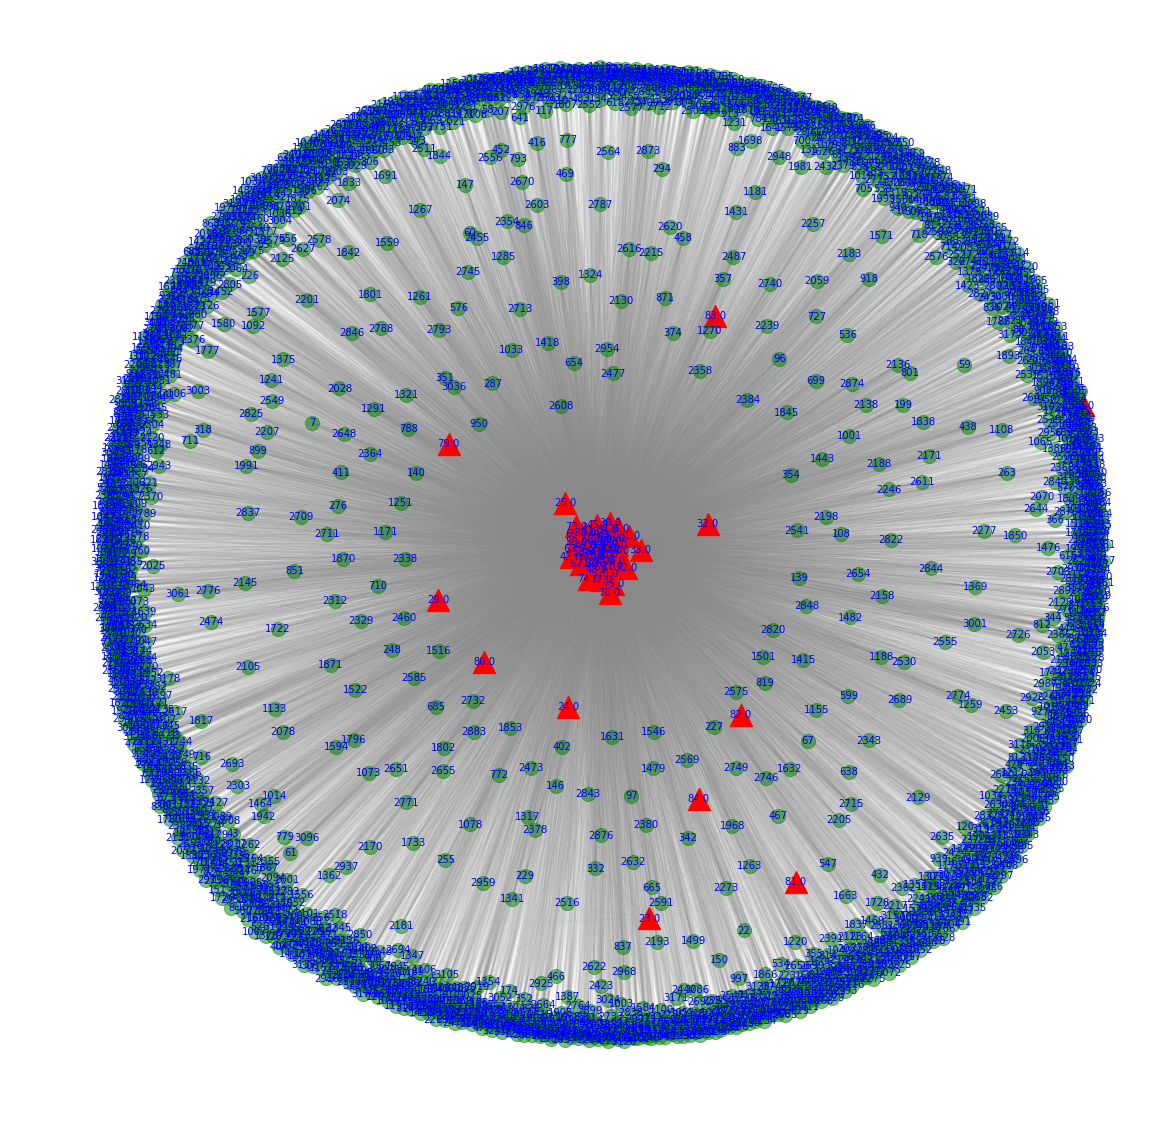

In [9]:
pos = nx.spring_layout(G,k=1.55,iterations=80)
pos_labels = {}
keys = pos.keys()
for key in keys:
    x, y = pos[key]
    pos_labels[key] = (x, y)
plt.figure(figsize=(20,20))
nx.draw_networkx_labels(G, pos_labels, font_color='Blue', font_size=10)
nx.draw_networkx_edges(G, pos, edge_color="Gray", alpha=0.05)
nx.draw_networkx_nodes(G, pos, nodelist=list(set(rides_by_temp["HOURLYDRYBULBTEMPF"].tolist())), node_color="r", node_shape="^", node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=list(set(rides_by_temp["driver_id"].tolist())), node_color="g", alpha=0.5, node_shape="o", node_size=200)
plt.axis('off')
plt.show()

The result is a bipartite graph. There are some temperatures with fewer drivers attached to them than others. Presumably, these are the two that are difficult to read hiding amongst the driver nodes.

## Analysis

We decided to look into the temperatures and the drivers, and how they interacted.

In [10]:
temperature_colors = {}
current_temp = [0, 0, 255]
for i in range(101):
    if current_temp[0] == 255:
        current_temp = [round(current_temp[0]), round(current_temp[1]-5.1,), round(current_temp[2]-5.1)]
        temperature_colors[float(i)] = '#%02x%02x%02x' % (current_temp[0], current_temp[1], current_temp[2])
    else:
        current_temp = [round(current_temp[0]+5.1), round(current_temp[1]+5.1), round(current_temp[2])]
        temperature_colors[float(i)] = '#%02x%02x%02x' % (current_temp[0], current_temp[1], current_temp[2])

Colors were assigned to every temperature from 0 to 100, even though this range is greater than the range of temperatures present in the dataset. The closer to 0 the temperature was, the more blue its color; the closer to 100, the more red.

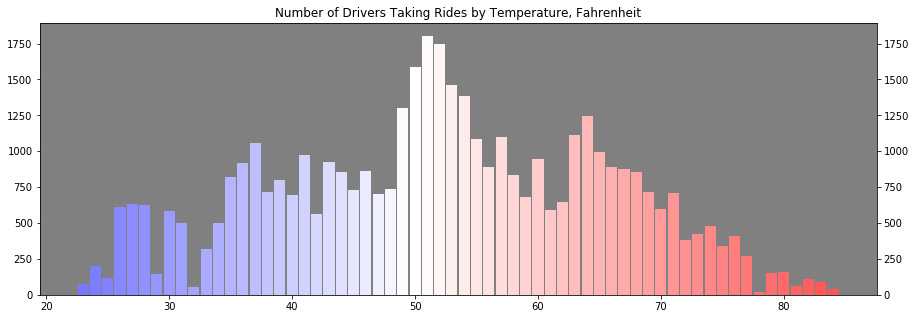

In [11]:
temp_drivers = {}
for temp in list(set(rides_by_temp["HOURLYDRYBULBTEMPF"].tolist())):
    temp_drivers[temp] = len(list(nx.all_neighbors(G, temp)))
plt.figure(figsize=(15,5))
plt.rcParams['axes.facecolor'] = 'gray'
plt.bar(temp_drivers.keys(), temp_drivers.values(), width=0.9, align="center", color=[temperature_colors[temp] for temp in list(set(rides_by_temp["HOURLYDRYBULBTEMPF"].tolist()))])
plt.tick_params(labelright=True, right=True)
plt.title("Number of Drivers Taking Rides by Temperature, Fahrenheit")
plt.show()

A bar plot was created to reflect the frequency of rides performed by drivers based on the temperature, Fahrenheit. The highest frequency of rides are found between 49 and 55 degrees.

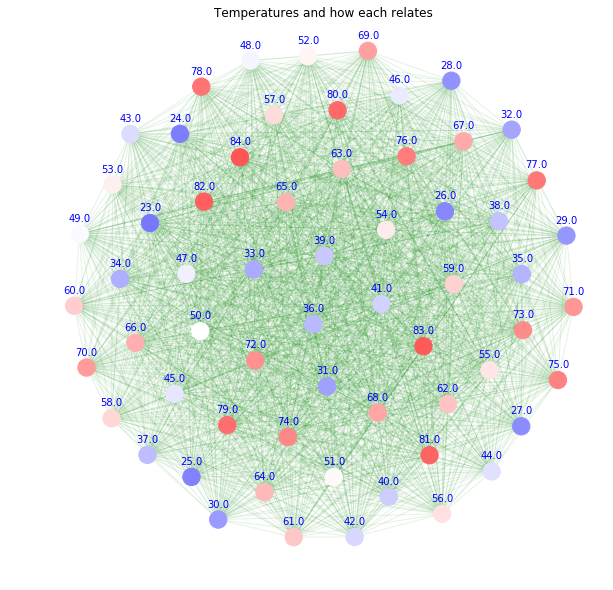

In [12]:
T = bipartite.projected_graph(G, list(set(rides_by_temp["HOURLYDRYBULBTEMPF"].tolist())))
plt.figure(figsize=(10,10))
pos = nx.spring_layout(T,k=0.55,iterations=80)
pos_labels = {}
keys = pos.keys()
for key in keys:
    x, y = pos[key]
    pos_labels[key] = (x, y+0.065)
nx.draw_networkx_labels(T, pos_labels, font_color='Blue', font_size=10)
nx.draw_networkx_edges(T, pos, edge_color='green', alpha=0.1)
nx.draw_networkx_nodes(T, pos, node_color=[temperature_colors[node] for node in T], node_size=300)
plt.axis("off")
plt.title("Temperatures and how each relates")
plt.show()

Similar to the barplot, this projected graph shows that temperatures that have drivers out and about more frequently are those closer to the center; those on the outskirts had fewer drivers out taking rides.

## Inference

Initial indications suggest that the more extreme the temperatures, the less drivers are taking rides. The data supports this assumption by the majority of the drivers being out during temperatures around the fifty degree mark, and less the colder or hotter it gets.

There was some debate within the group if this was a matter of driver preference or rider preference. For example, it was suggested that drivers might be less willing to accept rides in cold weather or that in warmer weather they're less likely to be driving. It was also discussion that the reason for less records of rides by drivers during temperature extremes had more to do with the riders, in that during colder temperatures fewer people bothered going to work or going out, period, and that during warmer temperatures riders chose instead to walk and enjoy the weather.

Regardless, 52 degrees plus or minus about 13 degrees Fahrenheit accounted for the majority of the drivers being out on the road.

## Conclusion

In conclusion, we discovered that drivers were more likely to be driving during moderate temperatures than during extreme temperatures.